
HYDROGEN SUPPLY CHAIN OPTIMIZATION MODEL

Time Horizon: 14 days
Number of Ports: 15
Ship Capacity: 500 tonnes
Boil-off Rate: 0.10%/day

----------------------------------------
Building optimization model...
Solving model...

OPTIMIZATION RESULTS SUMMARY

Optimization Status: Optimal
Total System Logistics Cost: ₹ 19,059,930.23

--- SHIPMENT METRICS ---
Total Hydrogen Transported: 25,070.42 tonnes
Average Logistics Cost: ₹ 760.26 per tonne
Average Daily Cost: ₹ 1,361,423.59 per day

--- BOIL-OFF LOSSES ---
Average Daily Boil-Off Loss: 9.87 tonnes/day
Total Hydrogen Lost due to Boil-Off: 138.23 tonnes
Total Hydrogen Produced: 20,300.00 tonnes
Fraction Lost to Boil-Off: 0.68%

--- INVENTORY METRICS ---
Cumulative Inventory Holding: 156,589.03 tonne-days

--- DEMAND SATISFACTION ---
Total Hydrogen Demand: 18,200.00 tonnes
Total Hydrogen Demand Unmet: 1,400.80 tonnes
Demand Satisfaction Rate: 92.30%

--- PORT-WISE BOIL-OFF (tonnes) ---
  Mumbai: 24.15
  Chennai: 1.50
  Kolkata: 9.43
  Koc

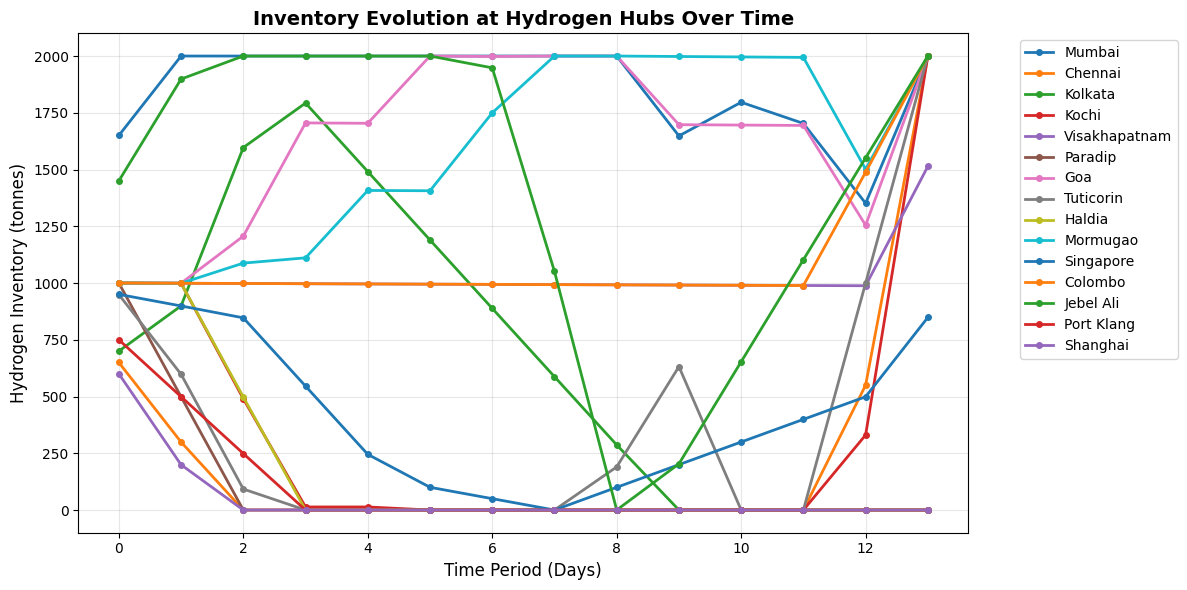

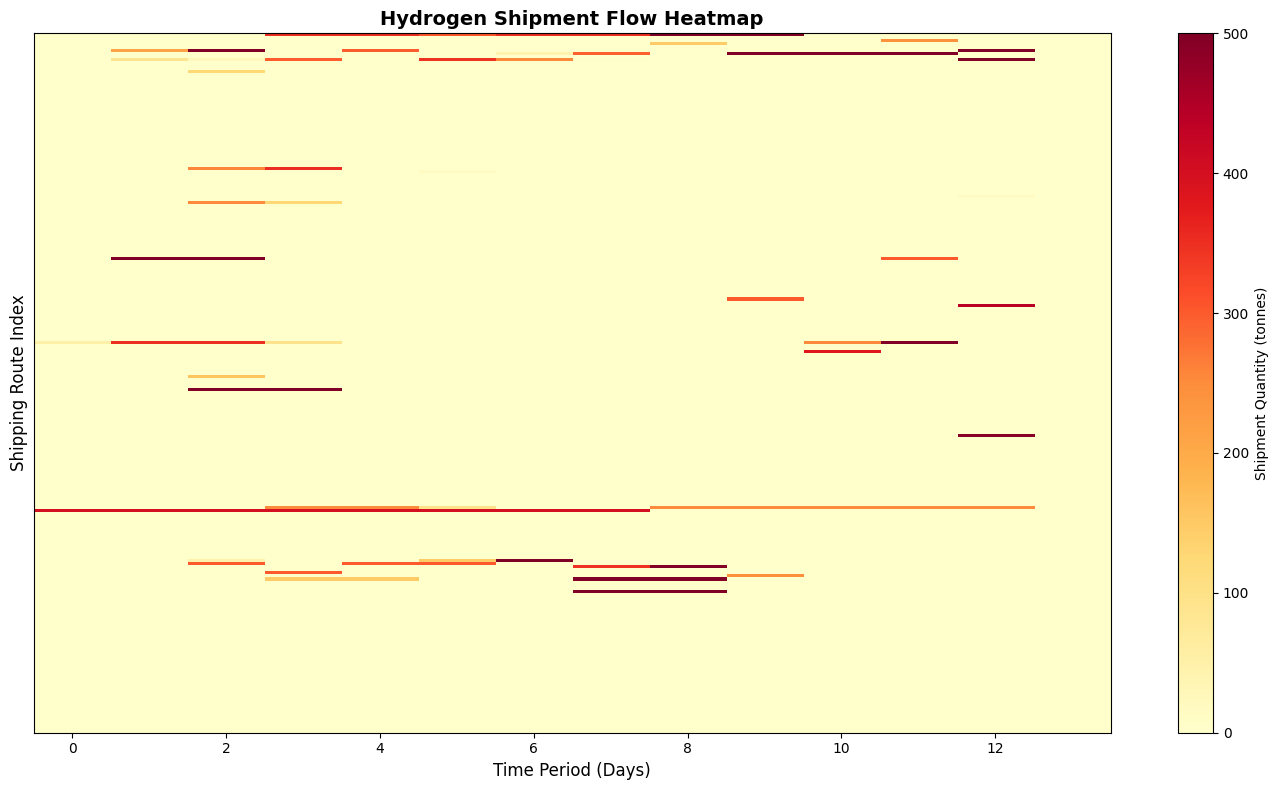


OPTIMIZATION COMPLETE


In [7]:
"""
Hydrogen Supply Chain Optimization Model
=========================================
Multi-period MILP model for maritime hydrogen transport planning with
inventory dynamics, boil-off, transit delays, and cost minimization.

This model optimizes the transportation of hydrogen between ports over
a multi-day planning horizon, considering:
- Production and demand at various ports
- Storage capacity constraints
- Boil-off losses during storage
- Maritime transport with transit delays
- Shipment capacity constraints
- Penalties for unmet demand

Author: [Aditya Singh]
Date: February 2026
"""

import math
import numpy as np
import pulp
import searoute as sr
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any


# =============================================================================
# CONSTANTS AND CONFIGURATION
# =============================================================================

# Time horizon configuration
TIME_HORIZON_DAYS = 14
TIME_PERIODS = range(TIME_HORIZON_DAYS)

# Physical parameters
SHIP_SPEED_KMPD = 720  # km per day
BOIL_OFF_RATE = 0.001  # 0.1% per day
SHIP_CAPACITY_TONS = 500  # tons per shipment
MAX_ROUTE_KM = 6000  # maximum feasible shipping distance

# Cost parameters
FUEL_COST_PER_KM = 0.15
CRYOGENIC_COST_PER_KM = 0.05
LEAK_PENALTY_PER_KM = 0.02
DEMAND_PENALTY_PER_TON = 5000  # penalty for unmet demand

# Initial inventory at all ports (tons)
INITIAL_INVENTORY = 1000


# =============================================================================
# PORT DATA AND DISTANCE MATRIX
# =============================================================================

PORT_COORDINATES = {
    "Mumbai": (18.94, 72.83),
    "Chennai": (13.08, 80.28),
    "Kolkata": (22.56, 88.34),
    "Kochi": (9.96, 76.27),
    "Visakhapatnam": (17.70, 83.30),
    "Paradip": (20.32, 86.61),
    "Goa": (15.40, 73.81),
    "Tuticorin": (8.77, 78.13),
    "Haldia": (22.03, 88.06),
    "Mormugao": (15.41, 73.81),
    "Singapore": (1.30, 103.77),
    "Colombo": (6.95, 79.85),
    "Jebel Ali": (25.00, 55.05),
    "Port Klang": (3.00, 101.40),
    "Shanghai": (31.23, 121.47)
}

PORT_NAMES = list(PORT_COORDINATES.keys())
N_PORTS = len(PORT_NAMES)
PORT_INDICES = range(N_PORTS)


def maritime_distance(
    lat1: float, lon1: float, lat2: float, lon2: float
) -> float:
    """
    Compute real maritime distance in km using searoute.
    
    Args:
        lat1, lon1: Coordinates of origin port
        lat2, lon2: Coordinates of destination port
        
    Returns:
        Distance in kilometers, or 0 for same port,
        999999.0 if route calculation fails
    """
    if abs(lat1 - lat2) < 1e-6 and abs(lon1 - lon2) < 1e-6:
        return 0.0
    
    origin = (lon1, lat1)
    destination = (lon2, lat2)
    
    try:
        route = sr.searoute(origin, destination)
        return route['properties']['length']
    except Exception:
        return 999999.0


# Precompute distance matrix
distance_matrix = np.zeros((N_PORTS, N_PORTS))
for i in range(N_PORTS):
    for j in range(N_PORTS):
        if i != j:
            lat1, lon1 = PORT_COORDINATES[PORT_NAMES[i]]
            lat2, lon2 = PORT_COORDINATES[PORT_NAMES[j]]
            distance_matrix[i, j] = maritime_distance(lat1, lon1, lat2, lon2)


# =============================================================================
# TRANSIT DELAY CALCULATION
# =============================================================================

# Calculate transit delays (rounded up to nearest day)
transit_delay = np.zeros((N_PORTS, N_PORTS), dtype=int)
for i in PORT_INDICES:
    for j in PORT_INDICES:
        if i != j:
            transit_delay[i, j] = math.ceil(
                distance_matrix[i, j] / SHIP_SPEED_KMPD
            )

# Mark infeasible routes (beyond max distance)
for i in PORT_INDICES:
    for j in PORT_INDICES:
        if distance_matrix[i, j] > MAX_ROUTE_KM:
            transit_delay[i, j] = TIME_HORIZON_DAYS + 1


# =============================================================================
# PRODUCTION AND DEMAND DATA
# =============================================================================

# Production hubs (tons per day)
production = np.zeros((N_PORTS, TIME_HORIZON_DAYS))
production[PORT_NAMES.index("Mumbai"), :] = 650
production[PORT_NAMES.index("Jebel Ali"), :] = 450
production[PORT_NAMES.index("Singapore"), :] = 350

# Demand centers (tons per day)
demand = np.zeros((N_PORTS, TIME_HORIZON_DAYS))
demand[PORT_NAMES.index("Chennai"), :] = 350
demand[PORT_NAMES.index("Kolkata"), :] = 300
demand[PORT_NAMES.index("Shanghai"), :] = 400
demand[PORT_NAMES.index("Port Klang"), :] = 250

# Storage capacity (tons)
storage_capacity = np.full(N_PORTS, 2000)


# =============================================================================
# COST MODEL
# =============================================================================

# Calculate transportation costs
fuel_cost_matrix = distance_matrix * FUEL_COST_PER_KM
cryo_cost_matrix = distance_matrix * CRYOGENIC_COST_PER_KM
leak_penalty_matrix = distance_matrix * LEAK_PENALTY_PER_KM
total_shipping_cost = fuel_cost_matrix + cryo_cost_matrix + leak_penalty_matrix


# =============================================================================
# MILP MODEL DEFINITION
# =============================================================================

def build_optimization_model() -> pulp.LpProblem:
    """
    Build the MILP optimization model for hydrogen supply chain.
    
    Returns:
        Configured PuLP model ready for solving
    """
    model = pulp.LpProblem("Hydrogen_Supply_Chain_Network", pulp.LpMinimize)
    
    # Decision variables
    # Shipment quantity from i to j at time t
    shipments = pulp.LpVariable.dicts(
        "shipment",
        (PORT_INDICES, PORT_INDICES, TIME_PERIODS),
        lowBound=0,
        cat=pulp.LpContinuous
    )
    
    # Inventory level at port i at time t
    inventory = pulp.LpVariable.dicts(
        "inventory",
        (PORT_INDICES, TIME_PERIODS),
        lowBound=0,
        cat=pulp.LpContinuous
    )
    
    # Unmet demand at port i at time t
    unmet_demand = pulp.LpVariable.dicts(
        "unmet_demand",
        (PORT_INDICES, TIME_PERIODS),
        lowBound=0,
        cat=pulp.LpContinuous
    )
    
    # =========================================================================
    # OBJECTIVE FUNCTION
    # =========================================================================
    
    # Transportation cost component
    transport_cost = pulp.lpSum(
        total_shipping_cost[i, j] * shipments[i][j][t]
        for i in PORT_INDICES
        for j in PORT_INDICES
        for t in TIME_PERIODS
        if i != j
    )
    
    # Unmet demand penalty component
    demand_penalty = DEMAND_PENALTY_PER_TON * pulp.lpSum(
        unmet_demand[i][t]
        for i in PORT_INDICES
        for t in TIME_PERIODS
    )
    
    model += transport_cost + demand_penalty
    
    # =========================================================================
    # CONSTRAINTS
    # =========================================================================
    
    # Inventory balance constraints
    for i in PORT_INDICES:
        for t in range(TIME_HORIZON_DAYS - 1):
            # Shipments arriving at time t+1
            arrivals = pulp.lpSum(
                shipments[j][i][t + 1 - transit_delay[j, i]]
                for j in PORT_INDICES
                if j != i and t + 1 - transit_delay[j, i] >= 0
            )
            
            # Outgoing shipments
            outgoing = pulp.lpSum(
                shipments[i][j][t + 1]
                for j in PORT_INDICES
                if j != i
            )
            
            # Actual demand satisfied
            demand_satisfied = demand[i, t + 1] - unmet_demand[i][t + 1]
            
            model += (
                inventory[i][t + 1]
                ==
                (1 - BOIL_OFF_RATE) * inventory[i][t]
                + production[i, t + 1]
                - outgoing
                + arrivals
                - demand_satisfied
            )
    
    # Storage capacity constraints
    for i in PORT_INDICES:
        for t in TIME_PERIODS:
            model += inventory[i][t] <= storage_capacity[i]
    
    # Shipment capacity constraints
    for i in PORT_INDICES:
        for j in PORT_INDICES:
            if i != j:
                for t in TIME_PERIODS:
                    model += shipments[i][j][t] <= SHIP_CAPACITY_TONS
    
    # Shipping horizon constraints (prevent late arrivals)
    for i in PORT_INDICES:
        for j in PORT_INDICES:
            if i != j:
                for t in TIME_PERIODS:
                    if t + transit_delay[i, j] >= TIME_HORIZON_DAYS:
                        model += shipments[i][j][t] == 0
    
    # Initial inventory constraints
    for i in PORT_INDICES:
        # Pre-existing shipments arriving at time 0
        initial_arrivals = pulp.lpSum(
            shipments[j][i][-transit_delay[j, i]]
            for j in PORT_INDICES
            if j != i and -transit_delay[j, i] >= 0
        )
        
        outgoing_initial = pulp.lpSum(
            shipments[i][j][0]
            for j in PORT_INDICES
            if j != i
        )
        
        model += (
            inventory[i][0]
            ==
            INITIAL_INVENTORY
            + production[i, 0]
            - outgoing_initial
            + initial_arrivals
            - demand[i, 0] + unmet_demand[i][0]
        )
    
    return model, shipments, inventory, unmet_demand


# =============================================================================
# SOLUTION ANALYSIS FUNCTIONS
# =============================================================================

def analyze_results(
    model: pulp.LpProblem,
    shipments: Dict,
    inventory: Dict,
    unmet_demand: Dict
) -> Dict[str, Any]:
    """
    Analyze optimization results and compute key performance indicators.
    
    Returns:
        Dictionary containing various metrics and analysis results
    """
    results = {}
    
    # Basic status
    results['status'] = pulp.LpStatus[model.status]
    results['objective_value'] = pulp.value(model.objective)
    
    if results['status'] != "Optimal":
        print(f"Warning: Model not solved to optimality. Status: {results['status']}")
        return results
    
    # Total shipments
    total_shipped = sum(
        pulp.value(shipments[i][j][t])
        for i in PORT_INDICES
        for j in PORT_INDICES
        for t in TIME_PERIODS
        if i != j
    )
    results['total_shipped_tons'] = total_shipped
    
    # Boil-off losses
    total_boiloff = 0
    for i in PORT_INDICES:
        for t in range(1, TIME_HORIZON_DAYS):
            total_boiloff += BOIL_OFF_RATE * pulp.value(inventory[i][t-1])
    results['total_boiloff_tons'] = total_boiloff
    results['avg_daily_boiloff'] = total_boiloff / TIME_HORIZON_DAYS
    
    # Port-wise boil-off
    port_boiloff = {}
    for i in PORT_INDICES:
        loss = sum(
            BOIL_OFF_RATE * pulp.value(inventory[i][t])
            for t in range(TIME_HORIZON_DAYS - 1)
        )
        port_boiloff[PORT_NAMES[i]] = loss
    results['port_boiloff'] = port_boiloff
    
    # Production totals
    total_production = sum(
        production[i, t]
        for i in PORT_INDICES
        for t in TIME_PERIODS
    )
    results['total_production_tons'] = total_production
    results['boiloff_fraction'] = (total_boiloff / total_production) * 100
    
    # Inventory metrics
    total_inventory = sum(
        pulp.value(inventory[i][t])
        for i in PORT_INDICES
        for t in TIME_PERIODS
    )
    results['cumulative_inventory_ton_days'] = total_inventory
    
    # Unmet demand analysis
    total_unmet = sum(
        pulp.value(unmet_demand[i][t])
        for i in PORT_INDICES
        for t in TIME_PERIODS
    )
    total_demand = sum(
        demand[i, t]
        for i in PORT_INDICES
        for t in TIME_PERIODS
    )
    
    results['total_unmet_tons'] = total_unmet
    results['total_demand_tons'] = total_demand
    results['demand_satisfaction_rate'] = 100 * (1 - total_unmet / total_demand)
    
    # Port-wise unmet demand
    port_unmet = {}
    for i in PORT_INDICES:
        unmet = sum(pulp.value(unmet_demand[i][t]) for t in TIME_PERIODS)
        port_unmet[PORT_NAMES[i]] = unmet
    results['port_unmet_demand'] = port_unmet
    
    # Cost metrics
    results['avg_cost_per_ton'] = results['objective_value'] / total_shipped
    results['avg_daily_cost'] = results['objective_value'] / TIME_HORIZON_DAYS
    
    # Store raw data for plotting
    results['inventory_data'] = {
        PORT_NAMES[i]: [pulp.value(inventory[i][t]) for t in TIME_PERIODS]
        for i in PORT_INDICES
    }
    
    results['shipment_matrix'] = np.zeros((N_PORTS * N_PORTS, TIME_HORIZON_DAYS))
    arc_idx = 0
    for i in PORT_INDICES:
        for j in PORT_INDICES:
            if i != j:
                for t in TIME_PERIODS:
                    results['shipment_matrix'][arc_idx, t] = pulp.value(shipments[i][j][t])
                arc_idx += 1
    
    return results


def print_results_summary(results: Dict[str, Any]) -> None:
    """
    Print formatted results summary.
    
    Args:
        results: Dictionary containing analysis results
    """
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS SUMMARY")
    print("="*60)
    
    print(f"\nOptimization Status: {results['status']}")
    print(f"Total System Logistics Cost: ₹ {results['objective_value']:,.2f}")
    
    print(f"\n--- SHIPMENT METRICS ---")
    print(f"Total Hydrogen Transported: {results['total_shipped_tons']:,.2f} tonnes")
    print(f"Average Logistics Cost: ₹ {results['avg_cost_per_ton']:,.2f} per tonne")
    print(f"Average Daily Cost: ₹ {results['avg_daily_cost']:,.2f} per day")
    
    print(f"\n--- BOIL-OFF LOSSES ---")
    print(f"Average Daily Boil-Off Loss: {results['avg_daily_boiloff']:,.2f} tonnes/day")
    print(f"Total Hydrogen Lost due to Boil-Off: {results['total_boiloff_tons']:,.2f} tonnes")
    print(f"Total Hydrogen Produced: {results['total_production_tons']:,.2f} tonnes")
    print(f"Fraction Lost to Boil-Off: {results['boiloff_fraction']:.2f}%")
    
    print(f"\n--- INVENTORY METRICS ---")
    print(f"Cumulative Inventory Holding: {results['cumulative_inventory_ton_days']:,.2f} tonne-days")
    
    print(f"\n--- DEMAND SATISFACTION ---")
    print(f"Total Hydrogen Demand: {results['total_demand_tons']:,.2f} tonnes")
    print(f"Total Hydrogen Demand Unmet: {results['total_unmet_tons']:,.2f} tonnes")
    print(f"Demand Satisfaction Rate: {results['demand_satisfaction_rate']:.2f}%")
    
    print(f"\n--- PORT-WISE BOIL-OFF (tonnes) ---")
    for port, loss in results['port_boiloff'].items():
        if loss > 0.1:  # Only show ports with significant losses
            print(f"  {port}: {loss:,.2f}")
    
    print(f"\n--- PORT-WISE UNMET DEMAND (tonnes) ---")
    for port, unmet in results['port_unmet_demand'].items():
        if unmet > 0.1:  # Only show ports with significant unmet demand
            print(f"  {port}: {unmet:,.2f}")


# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_inventory_evolution(results: Dict[str, Any]) -> None:
    """
    Plot inventory levels over time for all ports.
    
    Args:
        results: Dictionary containing analysis results
    """
    plt.figure(figsize=(12, 6))
    
    for port_name, inventory_levels in results['inventory_data'].items():
        if max(inventory_levels) > 1:  # Only plot ports with significant inventory
            plt.plot(
                TIME_PERIODS,
                inventory_levels,
                marker='o',
                linewidth=2,
                markersize=4,
                label=port_name
            )
    
    plt.xlabel("Time Period (Days)", fontsize=12)
    plt.ylabel("Hydrogen Inventory (tonnes)", fontsize=12)
    plt.title("Inventory Evolution at Hydrogen Hubs Over Time", fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_shipment_heatmap(results: Dict[str, Any]) -> None:
    """
    Plot heatmap of shipments over time.
    
    Args:
        results: Dictionary containing analysis results
    """
    plt.figure(figsize=(14, 8))
    
    plt.imshow(results['shipment_matrix'], aspect='auto', cmap='YlOrRd')
    plt.colorbar(label='Shipment Quantity (tonnes)')
    
    plt.xlabel("Time Period (Days)", fontsize=12)
    plt.ylabel("Shipping Route Index", fontsize=12)
    plt.title("Hydrogen Shipment Flow Heatmap", fontsize=14, fontweight='bold')

    plt.yticks([])
    
    plt.tight_layout()
    plt.show()


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main() -> None:
    """Main execution function."""
    print("\n" + "="*60)
    print("HYDROGEN SUPPLY CHAIN OPTIMIZATION MODEL")
    print("="*60)
    print(f"\nTime Horizon: {TIME_HORIZON_DAYS} days")
    print(f"Number of Ports: {N_PORTS}")
    print(f"Ship Capacity: {SHIP_CAPACITY_TONS} tonnes")
    print(f"Boil-off Rate: {BOIL_OFF_RATE*100:.2f}%/day")
    
    # Build and solve model
    print("\n" + "-"*40)
    print("Building optimization model...")
    model, shipments, inventory, unmet_demand = build_optimization_model()
    
    print("Solving model...")
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Analyze results
    results = analyze_results(model, shipments, inventory, unmet_demand)
    
    # Print summary
    print_results_summary(results)
    
    # Generate plots
    if results['status'] == "Optimal":
        print("\n" + "-"*40)
        print("Generating visualizations...")
        plot_inventory_evolution(results)
        plot_shipment_heatmap(results)
    
    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE")
    print("="*60)


if __name__ == "__main__":
    main()